In [1]:
#fine tuning models

#if in doubt... run the code

#with feature extraction all of the layers are remained frozen

#with fine tuning there is not limit to how many layers you can freeze and unfreeze, usually requires more data because it needs to learn actual new patterns

#exploring the functional api

#exploring the model checkpoints callback

In [2]:
#Transfer learning with tensorflow part two -- fine tuning, in the previous notebook we covered featured extraction

#now its time to learn about fine tuning

In [3]:
!nvidia-smi #tesla t4 gpu

Thu Mar 20 23:31:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**when it times out** colab will delete helper functions.py so will need to rerun the cells above

In [4]:
#lets get the data, this time lets use the pretrained models within tf.keras.applications -- this is what i used last time because tensorhub wasnt working

In [5]:
#get 10% of training data and 10 classes of food 101

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2025-03-20 23:31:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 108.177.98.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   124MB/s    in 1.3s    

2025-03-20 23:31:21 (124 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [7]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

there are 2 directories and 0 images in 10_food_classes_10_percent
there are 10 directories and 0 images in 10_food_classes_10_percent/test
there are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
there are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
there are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
there are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
there are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
there are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
there are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
there are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
there are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
there are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
there are 10 directori

In [8]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [9]:
import tensorflow as tf

#lets try something other than image data generator

#this will allow us to create a tf.data.dataset, this is faster and creates a dataset for us,
#image datag generator is the old one and still useful to understand

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    label_mode = "categorical"
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
train_data_10_percent #here we can see this function turned our data into batches,
#None is leaving a dimension in our tensor for different batches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [11]:
#check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [12]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels) #later we will need to normalize this dataset

tf.Tensor(
[[[[1.43198990e+02 1.03198982e+02 5.29132652e+01]
   [1.52214279e+02 1.07000000e+02 6.51938782e+01]
   [1.56571426e+02 1.07000000e+02 7.10816345e+01]
   ...
   [7.21940804e+00 1.61576523e+02 1.65790817e+02]
   [8.14283943e+00 1.60142838e+02 1.65142838e+02]
   [1.05969391e+01 1.57596939e+02 1.65596939e+02]]

  [[1.45357147e+02 1.05357147e+02 5.50714264e+01]
   [1.53938782e+02 1.09852043e+02 6.51428604e+01]
   [1.56372452e+02 1.07397964e+02 6.96683655e+01]
   ...
   [7.52553511e+00 1.62612228e+02 1.62637772e+02]
   [1.06428757e+01 1.62642883e+02 1.65642883e+02]
   [1.81173382e+01 1.66045914e+02 1.70260193e+02]]

  [[1.46923477e+02 1.05933670e+02 5.74285698e+01]
   [1.54142853e+02 1.09928574e+02 6.51428604e+01]
   [1.57571426e+02 1.09000000e+02 6.85714264e+01]
   ...
   [6.40822887e+00 1.61933716e+02 1.57811279e+02]
   [1.51429090e+01 1.68142914e+02 1.65928619e+02]
   [1.37142944e+01 1.62704102e+02 1.61994904e+02]]

  ...

  [[1.28321457e+02 1.22250008e+02 9.43213959e+01]
   [1

In [13]:
def create_tensorboard_callback(dirname, experiment_name):
  """creates a tensorboard callback instand to store log files.

  stores log files with the filepath:
  "dir_name/experiment_name/current_datetime/

  Args:
    dir_name: target directory to store tensorboard log files
    experiment_name: name of experiment directory
  """
  import datetime
  log_dir = dirname+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f"saving tensorboard logfiles to : {log_dir}")
  return tensorboard_callback

In [14]:
#the functional api is more sophisticated and able to build more compilated models

#model 0 :building a transfer learning model using the keras functional api

#1. create the base model with tf.keras.applications
import tensorflow
import pandas
from tensorflow import keras

#create the base model
base_model = keras.applications.EfficientNetB0(include_top = False) #because we want to add our own dense layer on the top

#freeze the base model (the underlying pre trained patterns)
base_model.trainable = False #it doesnt get trained

#create inputs into our model
inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = "input_layer"),

#if using a model like resnet50V2 you will need to normalize inputs, you dont have to for effiecientnet
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)

#passing input tensors thorugh our base model
x = base_model(inputs)
print(f"shape after passing inputs throguh base model : {x.shape}")

#average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x) #this is the functional api design we put what we want to pass to the layer at the end
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

#create the output acitvation layer
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

#combine the inputs with the outputs
model_0 = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
shape after passing inputs throguh base model : (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


In [15]:
#compile the model
model_0.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

history_0 = model_0.fit(train_data_10_percent, epochs = 5, steps_per_epoch = len(train_data_10_percent),
                        validation_data = test_data, validation_steps = int(0.25 *len(test_data)),
                        callbacks = [create_tensorboard_callback(dirname="transfer_learning", experiment_name="10_percent_feature_extraction")])

saving tensorboard logfiles to : transfer_learning/10_percent_feature_extraction/20250320-233145
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ('input_layer',)
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(None, 224, 224, 3))',)
  warnings.warn(msg)


24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 822ms/step - accuracy: 0.2977 - loss: 2.0992 - val_accuracy: 0.7303 - val_loss: 1.2697
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.7378 - loss: 1.1836 - val_accuracy: 0.8306 - val_loss: 0.8441
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.8366 - loss: 0.8307 - val_accuracy: 0.8586 - val_loss: 0.6563
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.8642 - loss: 0.6291 - val_accuracy: 0.8536 - val_loss: 0.5933
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.8863 - loss: 0.5371 - val_accuracy: 0.8684 - val_loss: 0.5308


In [16]:
#much faster because we sped up the validation steps
model_0.evaluate(test_data) #evaluation on the full test data

79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.8628 - loss: 0.5501


[0.5510485172271729, 0.8611999750137329]

In [17]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [18]:
#how about we get a summary of the base model
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, None, None, 3)  │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, None, None, 3)  │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, None, None, 3)  │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, None, None, 32) │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, None, None, 32) │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, None, None, 32) │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [19]:
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

In [20]:
#weve used the functional api and not tensorboard hub

#the only trainable perameters are inside the output_layer
import matplotlib.pyplot as plt
import pandas as pd
def plot_loss_curves(history):

  plt.figure()
  plt.title(f"training vs val accuracy")
  plt.xlabel("epochs")
  pd.DataFrame(history.history)["accuracy"].plot()
  pd.DataFrame(history.history)["val_accuracy"].plot()
  plt.legend()

  plt.figure()
  plt.title("training vs val loss")
  plt.xlabel("epochs")
  pd.DataFrame(history.history)["loss"].plot()
  pd.DataFrame(history.history)["val_loss"].plot()
  plt.legend();

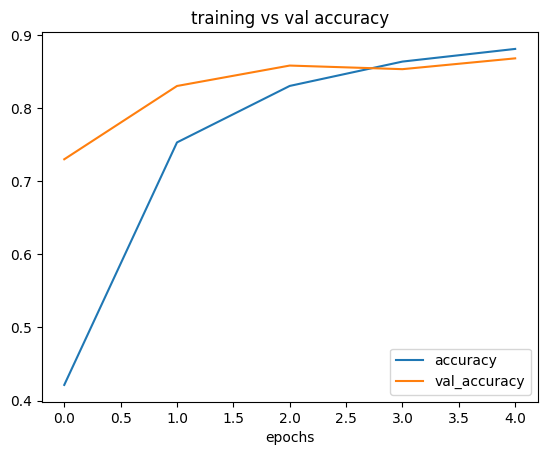

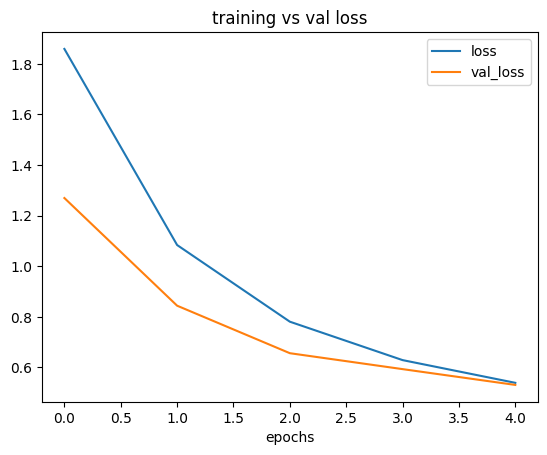

In [21]:
plot_loss_curves(history_0)

In [22]:
#what is a feature vector? if in doubt code it out

##getting a feature vector from a trained model

#lets demoontrate the globalaveragepooling2D layer

input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

#pass the random tensor thorugh a GlobalAveragePooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_average_pooled_tensor}\n")

#its gotten rid of the two middle dimensions and turns it into a feature vector

print(f"shape of input tensor: {input_tensor.shape}")
print(f"shape of global average pool 2D tensor: {global_average_pooled_tensor.shape}")

#then this vector is the input to our final dense layer, its just average across the middle two axis


Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

shape of input tensor: (1, 4, 4, 3)
shape of global average pool 2D tensor: (1, 3)


In [23]:
#lets replicate this function
tf.reduce_mean(input_tensor, axis = [1, 2]) #this is the same thing

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [24]:
#this layer feature extracts what the base model has learned, we dont know what they mean but our model understands it, then we train the output layer on this

In [25]:
#try to do the same with the above 2 cells but use global max pool 2D

input_shape = (1, 4, 4, 3)

#lets test what globalmaxpool2D does,
tf.random.set_seed(72)
random_tensor = tf.random.normal(input_shape)
print(f"random input tensor: \n {random_tensor} \n")

global_max_pool_2d = tf.keras.layers.GlobalMaxPool2D()(random_tensor)
print(f"global_max_pooled_tensor: \n {global_max_pool_2d}\n")

print(f"shape of input tensor: {random_tensor.shape}")
print(f"shape of global average pool 2D tensor: {global_max_pool_2d.shape}")



random input tensor: 
 [[[[-0.9851414   0.3167305  -0.19471097]
   [ 1.0504813   1.3002806   0.41464856]
   [-0.27045193  0.6269911  -0.02495955]
   [-1.3955908  -0.1800404   0.86390865]]

  [[ 0.85751915 -1.6810629   1.5096496 ]
   [ 0.26255357 -2.2718375   0.51156527]
   [ 1.6555442   0.18201731  0.02711758]
   [ 0.40695843 -0.34981218 -0.8698743 ]]

  [[ 0.32497284 -0.07156989  0.29931206]
   [-0.8269964   0.79127276  1.8398114 ]
   [-1.0032867   2.7072253  -0.68948084]
   [-0.92813075  1.3237076   1.4332709 ]]

  [[ 0.27907762 -0.36844012 -0.64679956]
   [ 0.24852292  0.03654931  1.169408  ]
   [-0.74890566  0.69842064 -0.8020147 ]
   [-0.67911327 -0.06700089  1.3257419 ]]]] 

global_max_pooled_tensor: 
 [[1.6555442 2.7072253 1.8398114]]

shape of input tensor: (1, 4, 4, 3)
shape of global average pool 2D tensor: (1, 3)


In [26]:
#this one works with the same methodology but takes the max at each position instead

In [27]:
#running a series of transfer learning experiments
#we've seen the incredible results transer learning can get with only 10 percent of the training data, but how does it go with only one percent of the training data

#model 1 feature extraction transer learning with 1% if the training data with data augmentation

#model_2 use feature extraction transfer learning with 10% if the training with data augmentation

#model_3 use fine tuning transfer learning on 10& of the training data with data augmentation

#model_4 upgrade the model to 100% of the training data

#always keep the testing data the same for consistency

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2025-03-20 23:33:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 108.177.98.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   238MB/s    in 0.5s    

2025-03-20 23:33:05 (238 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [28]:
import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_1_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [29]:
import os

for dirpath, dirnames,filenames in os.walk("10_food_classes_1_percent"):
  print(f"there are {len(dirnames)} directories, and {len(filenames)} images, in {dirpath}")

there are 2 directories, and 0 images, in 10_food_classes_1_percent
there are 10 directories, and 0 images, in 10_food_classes_1_percent/test
there are 0 directories, and 250 images, in 10_food_classes_1_percent/test/ice_cream
there are 0 directories, and 250 images, in 10_food_classes_1_percent/test/hamburger
there are 0 directories, and 250 images, in 10_food_classes_1_percent/test/steak
there are 0 directories, and 250 images, in 10_food_classes_1_percent/test/ramen
there are 0 directories, and 250 images, in 10_food_classes_1_percent/test/chicken_curry
there are 0 directories, and 250 images, in 10_food_classes_1_percent/test/grilled_salmon
there are 0 directories, and 250 images, in 10_food_classes_1_percent/test/sushi
there are 0 directories, and 250 images, in 10_food_classes_1_percent/test/chicken_wings
there are 0 directories, and 250 images, in 10_food_classes_1_percent/test/pizza
there are 0 directories, and 250 images, in 10_food_classes_1_percent/test/fried_rice
there are 

In [30]:
train_dir = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [31]:
import pathlib
import numpy as np

data_dir = pathlib.Path(train_dir)

classes = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(classes)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [32]:
def view_random_image(target_dir):
  import random
  import matplotlib.pyplot as plt
  import matplotlib.image as mpimg
  #gather a random class to show
  random_class = random.choice(classes)

  #create the target folder where the image exists
  target_folder = target_dir+random_class

  #getting a random image from the folder
  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0]) #need to index 0 to actually retrive the image

  plt.imshow(img)
  plt.axis("off")
  plt.title(random_class)

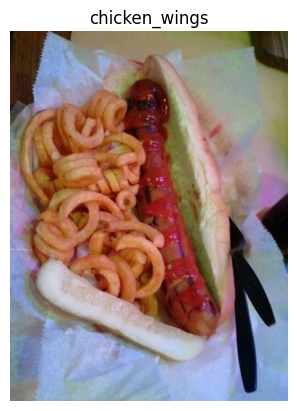

In [33]:
view_random_image(train_dir)

In [34]:
import tensorflow as tf
from tensorflow import keras

In [35]:
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = (224, 224),
    batch_size = 32,
    label_mode = "categorical"
)

Found 70 files belonging to 10 classes.


In [36]:
data_augmentation = keras.Sequential([
    tf.keras.layers.Input(shape = (224, 224, 3)),
    tf.keras.layers.RandomFlip("horizontal"), #randomly flip each image horizontally, vertical does make sense for our model
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2), #randomly zoom into some photos
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2)
], name = "data_augmentation")

(np.float64(-0.5), np.float64(514.5), np.float64(344.5), np.float64(-0.5))

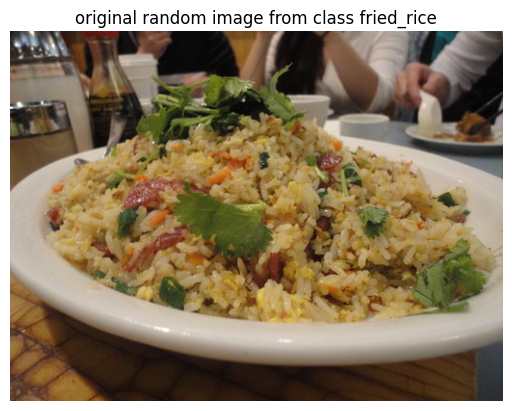

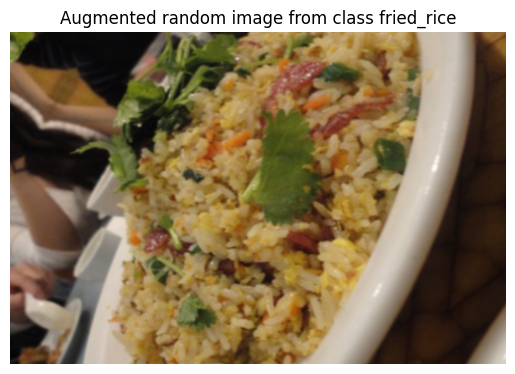

In [37]:
#view a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir+"/"+random_image

#read the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"original random image from class {target_class}")
plt.axis(False)

#now lets plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis = 0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class {target_class}")
plt.axis(False)

In [38]:
import tensorflow as tf
from tensorflow import keras

input_shape = (224, 224, 3)
base_model = keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False #freezing the weights and biases in the base model to aaply what  it learned to our classes


#adding data augmentation right into the model, we used to use this inside the ImageDataGenerator
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")

"""
This is how i did data augmentation on my own, but I discovered we can use the sequential api
to create the data augmentation and then implement that into the functional model:

inputs = tf.keras.layers.Rescaling(1./255.)(inputs)
inputs = tf.keras.layers.RandomFlip("horizontal_and_vertical")(inputs)
inputs = tf.keras.layers.RandomRotation(0.2)(inputs)
"""

"""
augmenting data inside the model makes augmentation run on the gpu, ImageDataGenerator makes the data augment on the cpu

"""
#adding the the data augmentation sequential model as a layer
x = data_augmentation(inputs) #needed to make sure the correct input shape was inside the augmentation model aswell above

#passing the proper input shape to the base model
x = base_model(x, training = False)

#passing the full inputs into the global average pooling layer to feature extract the most important information
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

#passing x to the output function after being converted into a vector
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

#make a model using the inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

In [39]:
model_1.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

#can also speed up training with validation_steps = int(0.25 * len(test_data))
history_1 = model_1.fit(train_data_1_percent, epochs = 5, steps_per_epoch = len(train_data_1_percent), validation_data = test_data, validation_steps = len(test_data), callbacks = [create_tensorboard_callback(dirname = "transfer_learning", experiment_name="1 percent data with augmentation")])

saving tensorboard logfiles to : transfer_learning/1 percent data with augmentation/20250320-233313
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.1157 - loss: 2.3918 - val_accuracy: 0.1616 - val_loss: 2.2119
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.2464 - loss: 2.1301 - val_accuracy: 0.2492 - val_loss: 2.0883
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.4220 - loss: 1.9109 - val_accuracy: 0.3292 - val_loss: 1.9812
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4609 - loss: 1.7694 - val_accuracy: 0.4000 - val_loss: 1.8866
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.5488 - loss: 1.6299 - val_accuracy: 0.4520 - val_loss: 1.7992


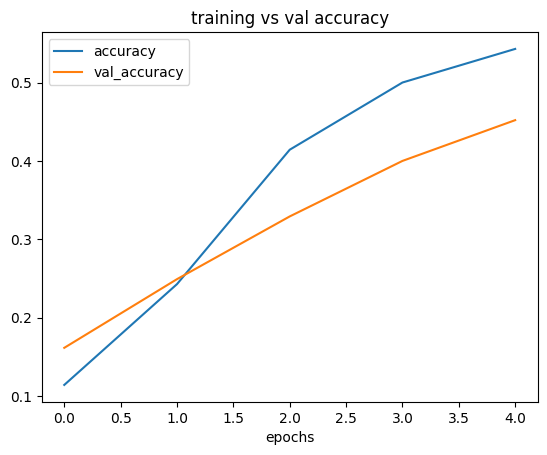

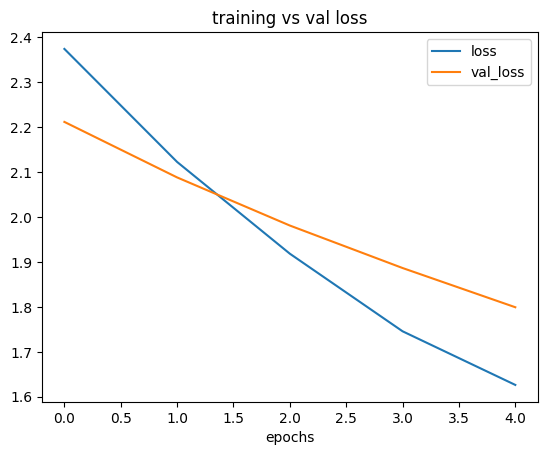

In [40]:
plot_loss_curves(history_1) #looks like a bit of overfitting, although even on one percent of the data the model is still doing very well on the validation set

#one percent of the data is only  7 representations per class, and the model still performs extremely well

#the model is probably overfitting to the training data because there is such little to learn so it easily learns everything

In [41]:
#evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug #not great on the full dataset but the loss curves are nice it isnt over fitting

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.4740 - loss: 1.7746


[1.799241065979004, 0.4519999921321869]

In [42]:
#model 2 will be the same preprocessing steps and model architecture as model 1 but on 10% of the data like model 0

#we already have 10 food classes 10 percent
#creating model 2

In [43]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [44]:
#set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [45]:
data_augmentation.summary()

Model: "data_augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_height (RandomHeight)         │ (None, None, 224, 3)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_width (RandomWidth)           │ (None, None, None, 3)       │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [46]:
#create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2)
    #rescaling is built into efficient net, if the model were resent we would need to rescale
], name = "data_augmentation") #cant get a summary here beacuse the model hasnt been used or built


input_shape = (224, 224, 3)

#create a frozen base model (also called backbone model)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

#create the inputs and outputs including the layers inbetween
inputs = layers.Input(shape = input_shape, name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False) #what this does is we pass the augmented images to the base model but keep the basemodel in inference mode, weights are not updated, batch norm layers dont get updated
#theres alot of batch normalization layers and trainable = false makes sure the weights stay the same

#create the global average pooling layer and pass it the outputs from the base model
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_2D")(x)

outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)


In [47]:
model_2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_2D            │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [48]:
model_2.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

#going to set up model check pointing

In [52]:
#creating a model check point callback saves our model during training. This is useful so we can stop and come back where we left off.

checkpoint_path = "10_percent_model_checkpoints_weights/checkpoint.ckpt.weights.h5"

#create a modelcheckpoint callback that saves the models weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch",
                                                         verbose = 1)


In [55]:
#fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_adata_aug = model_2.fit(train_data_10_percent,
                                           epochs = initial_epochs,
                                           validation_data = test_data,
                                           validation_steps = int(0.25 * len(test_data)),
                                           callbacks = [create_tensorboard_callback(dirname = "transfer_learning", experiment_name="10_percent_data_aug"),
                                                        checkpoint_callback])

saving tensorboard logfiles to : transfer_learning/10_percent_data_aug/20250320-233913
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.2151 - loss: 2.2228
Epoch 1: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 314ms/step - accuracy: 0.2201 - loss: 2.2149 - val_accuracy: 0.7368 - val_loss: 1.4043
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6527 - loss: 1.4389
Epoch 2: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.6535 - loss: 1.4355 - val_accuracy: 0.8372 - val_loss: 0.9553
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7779 - loss: 1.0665
Epoch 3: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.7778 - loss: 1.0653 - val_accuracy: 0.8635 - val_loss: 0.7405
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s

In [ ]:
#probably better to only save the last check point, because now we only end up with the last one

In [56]:
model_0.evaluate(test_data) #the non augmented data was actually better than the augmented data

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.8741 - loss: 0.5276


[0.551048755645752, 0.8611999750137329]

In [62]:
model_2_results = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.8611 - loss: 0.5989


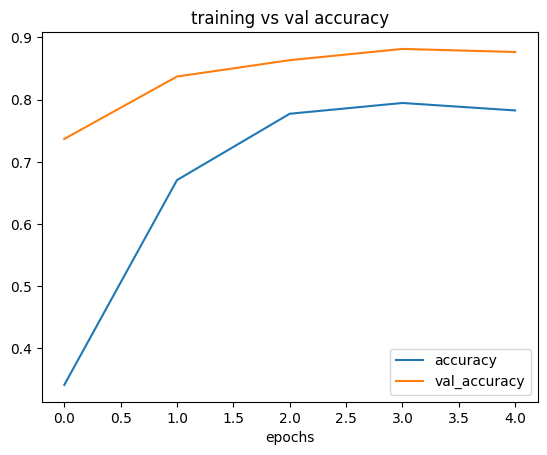

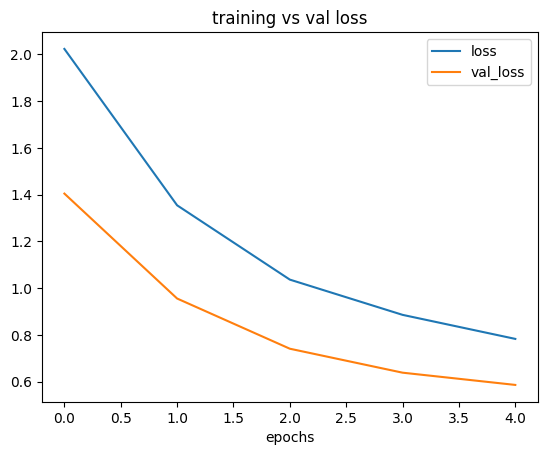

In [58]:
plot_loss_curves(history_10_percent_adata_aug) #seems like there may be room for imporvement with a few more epochs

In [59]:
#loading in check pointed weights, returns a model to a specific checkpoint.

#load in saved model weights and evaluate
model_2.load_weights(checkpoint_path)

In [60]:
#evaluate model 2 with loaded weights, previous weights should be overrided with the same weights and achieve the same results
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.8623 - loss: 0.5964


In [61]:
model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.8581 - loss: 0.6042


[0.6305863857269287, 0.8416000008583069]

In [63]:
import numpy as np
np.isclose(np.array(loaded_weights_model_results), np.array(model_2_results))

array([ True,  True])

In [64]:
#the numbers are close meaning the weights were likely transfered

#time to build our first fine tuning transfer learning model:

#what layers are in our base model (efficientnetb0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable) #trainable == false means the layers are frozen, we want to set the top layers to be True so the
  #model can learn and adjust to our own data

0 input_layer_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [72]:
#how many trainable variables in our base model
print(len(model_2.layers[2].trainable_variables)) # now zero we want to make at least 10 of them trainable

10


In [69]:
#to begin fine tuning lets start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

#freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [73]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

  #because base_model was a part of model 2 we can now recompile model 2 and fit it with the new unfrozen layers inside the base model

0 input_layer_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [ ]:
#recompile our model everytime we make a change

model_2.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), #lower the learning rate by 10x
    metrics = ["accuracy"]
)

#because we are updating already learned weights in our model, we dont want to update them too much,
#this is decided by the learning rate, because that would result in overfitting
#the general rule is to lower the learning rate by 10x

In [74]:
#now we've unfrozen some of the layers closer to the top, how many trainable variables are there
print(len(model_2.trainable_variables))

12


In [75]:
#fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

#refit the model (same as model 2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25 * len(test_data)),
                                               initial_epoch = history_10_percent_adata_aug.epoch[-1],
                                               callbacks = create_tensorboard_callback(dirname = "transfer_learning",
                                                                                       experiment_name = "10_percent_fine_tune_last_10_layers"))

saving tensorboard logfiles to : transfer_learning/10_percent_fine_tune_last_10_layers/20250321-001429
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.8467 - loss: 0.6902 - val_accuracy: 0.8734 - val_loss: 0.5489
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 432ms/step - accuracy: 0.8292 - loss: 0.6614 - val_accuracy: 0.8783 - val_loss: 0.5055
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.8599 - loss: 0.5915 - val_accuracy: 0.8651 - val_loss: 0.4971
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.8632 - loss: 0.5533 - val_accuracy: 0.8766 - val_loss: 0.4623
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.8633 - loss: 0.5348 - val_accuracy: 0.8701 - val_loss: 0.4735
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.8805 - loss: 0.5142 - val_accuracy: 0.8898 - val_loss: 0.4343


In [76]:
#evaluate the fine_tuned model (model_3 which is actually model_2 fine tuned another 10 epochs)

#we gained about 3 percentage points in perfromance by fine tuning the last 10 layers
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.8704 - loss: 0.4691


In [77]:
model_2_results

[0.6305864453315735, 0.8416000008583069]

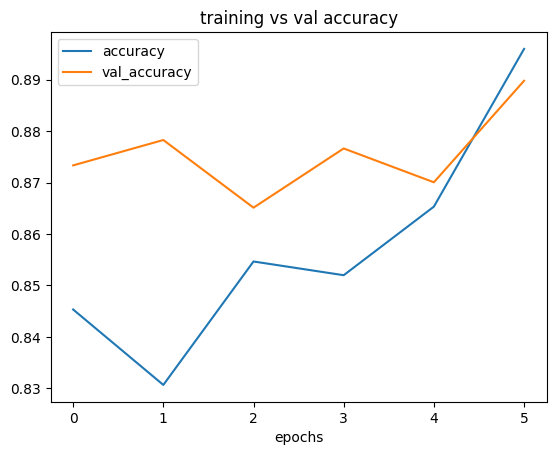

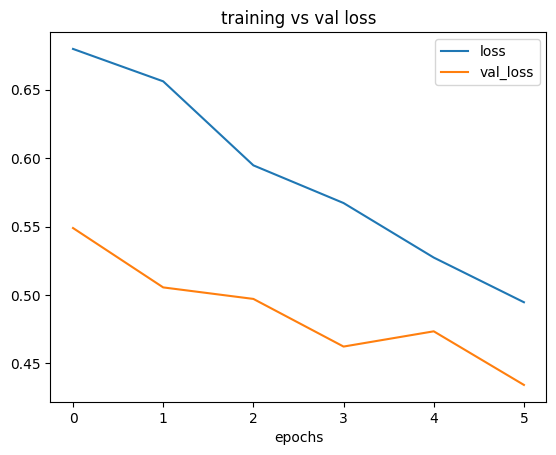

In [78]:
plot_loss_curves(history_fine_10_percent_data_aug) #its actually the epochs 5-10

In [85]:
#we want to plot our models results before finetuning and after finetuning
def compare_histories(original_history, new_history, initial_epochs = 5):
  """
  compares two tensorflow history objects.
  """

  #get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]


  #combine original history metrics with new history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  #make plots for accuracy
  plt.figure(figsize = (8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label ="training accuracy")
  plt.plot(total_val_acc, label = "validation accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = "start fine tuning")
  plt.legend(loc = "lower right")
  plt.title("Training and validation accuracy")


  #make plot for loss
  plt.figure(figsize = (8,8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label = "training loss")
  plt.plot(total_val_loss, label = "validation loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = "started fine tuning")
  plt.legend(loc = "upper right")
  plt.title("Training and Validation Loss");

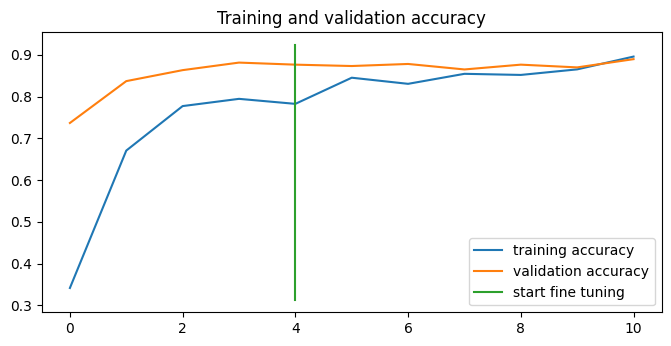

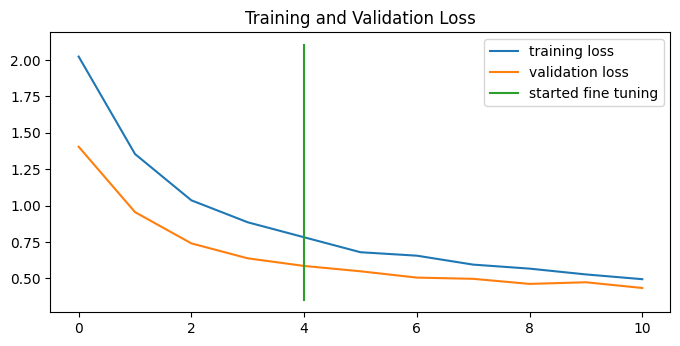

In [86]:
compare_histories(
    history_10_percent_adata_aug,
    history_fine_10_percent_data_aug
)

In [87]:
#time to recreate model 3 on 100% of the data images..

#typical work flow, train a feature extraction model first and then go into fine tuning of the model.

import zipfile

#download and unzip food classes with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

#this loads the data into a directory in colab

--2025-03-21 00:40:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.207, 74.125.195.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   124MB/s    in 14s     

2025-03-21 00:40:32 (36.5 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [88]:
#set up training and test dirs
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories, and {len(filenames)} images, in {dirpath}")
#for this we only pass 10_food_classes_all_data no .zip because when we unzip it that drops off

  #now we can see the dataset is full with 750 training images

There are 2 directories, and 0 images, in 10_food_classes_all_data
There are 10 directories, and 0 images, in 10_food_classes_all_data/test
There are 0 directories, and 250 images, in 10_food_classes_all_data/test/ice_cream
There are 0 directories, and 250 images, in 10_food_classes_all_data/test/hamburger
There are 0 directories, and 250 images, in 10_food_classes_all_data/test/steak
There are 0 directories, and 250 images, in 10_food_classes_all_data/test/ramen
There are 0 directories, and 250 images, in 10_food_classes_all_data/test/chicken_curry
There are 0 directories, and 250 images, in 10_food_classes_all_data/test/grilled_salmon
There are 0 directories, and 250 images, in 10_food_classes_all_data/test/sushi
There are 0 directories, and 250 images, in 10_food_classes_all_data/test/chicken_wings
There are 0 directories, and 250 images, in 10_food_classes_all_data/test/pizza
There are 0 directories, and 250 images, in 10_food_classes_all_data/test/fried_rice
There are 10 directori

In [89]:
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [90]:
#set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    label_mode = "categorical",
    image_size = IMG_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size = IMG_SIZE,
    label_mode = "categorical"
)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [91]:
#the test dataset we've loaded in is the same test dataset we've used for previous experiments

#evaluate_model on the new test_data (fine_tuned model_2)
model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.8662 - loss: 0.4740


[0.48629164695739746, 0.8600000143051147]

In [92]:
results_fine_tune_10_percent #these numbers line up perfectly

[0.4862915873527527, 0.8600000143051147]

In [93]:
#need to revert model 2 back to its feature extracted version, we cant continue to differentiate between our models perfromace

#load weights from checkpoint that way we can fine tune from the same stage the 10_percent model was fine tuned from

model_2.load_weights(checkpoint_path)

In [94]:
#lets evaluate model 2 now, ideally the results should be worse now, with the original results
model_2.evaluate(test_data) #and it is indeed 2% lower

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.8524 - loss: 0.6177


[0.6305864453315735, 0.8416000008583069]

In [95]:
model_2_results #same as old model 2 results

[0.6305864453315735, 0.8416000008583069]

In [96]:
#check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

  #if any are trainable efficientnetb0 will print out true

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [97]:
#lets drill into our base_model and see which layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [98]:
#we reverted the model to a different old set of weights, the layers unfrozen remained unfrozen

#now we need to recompile our model again

model_2.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    metrics = ["accuracy"]
)

In [99]:
#continue to train and finetune the model to ourdata
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs = fine_tune_epochs,
                                           validation_data = test_data,
                                           validation_steps = int(0.25 * len(test_data)),
                                           initial_epoch = history_10_percent_adata_aug.epoch[-1],
                                           callbacks = [create_tensorboard_callback(dirname = "transfer_learning", experiment_name = "full_10_classes_fine_tuned_last_10")])

saving tensorboard logfiles to : transfer_learning/full_10_classes_fine_tuned_last_10/20250321-010515
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 46s 139ms/step - accuracy: 0.7493 - loss: 0.8562 - val_accuracy: 0.8947 - val_loss: 0.3410
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 30s 128ms/step - accuracy: 0.8123 - loss: 0.6096 - val_accuracy: 0.9013 - val_loss: 0.3109
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 124ms/step - accuracy: 0.8249 - loss: 0.5408 - val_accuracy: 0.9095 - val_loss: 0.2780
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 29s 123ms/step - accuracy: 0.8442 - loss: 0.4925 - val_accuracy: 0.8980 - val_loss: 0.2908
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - accuracy: 0.8485 - loss: 0.4584 - val_accuracy: 0.9145 - val_loss: 0.2260
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.8587 - loss: 0.4429 - val_accuracy: 0.9095 - val_loss: 0.2521


In [100]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.9150 - loss: 0.2471


[0.2734312117099762, 0.9107999801635742]

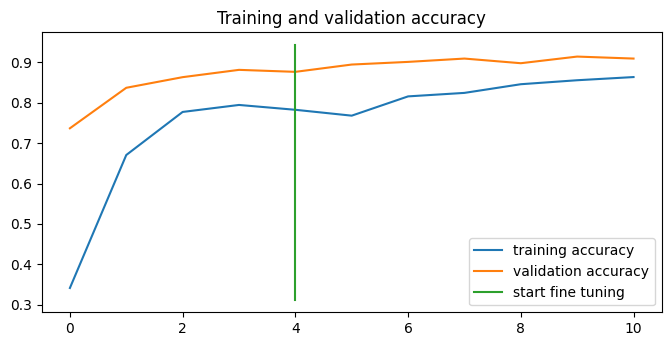

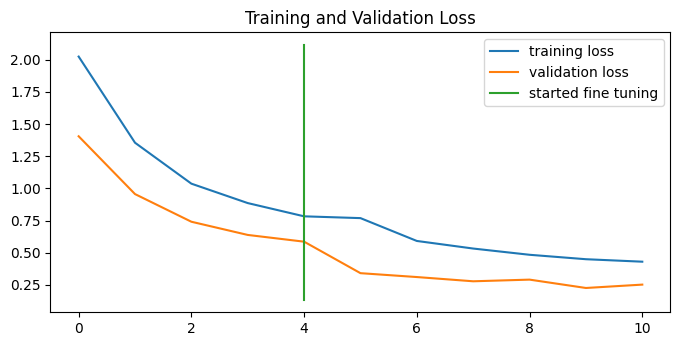

In [101]:
compare_histories(history_10_percent_adata_aug, history_fine_10_classes_full)

In [ ]:
#now we have to compare our experiments.